# XGA luminosity, temperature, and radius pipeline for galaxy clusters

This notebook serves to demonstrate the use of an XGA pipeline (or 'tool'). These pipelines do not necessarily take advantage of the interactive and highly customisable nature of XGA sources, samples, and general analyses, but will take information on a sample of objects and provide a set output of information without further interaction by the user. 

The XGA luminosity, temperature, and radius measurement pipeline for galaxy clusters will take information about the positions, redshifts, and names of a sample of galaxy clusters, and provide the user with a set of overdensity radius, temperature, and luminosity measurements (for those clusters which have available observations). You do not need to know a priori whether a cluster in the input sample has X-ray data available, XGA will determine that for you and simply ignore those clusters which do not.

We explain how the pipeline works, demonstrate its use, and explain the information that it returns and saves to disk (if requested by the user). We also demonstrate that $R_{500}$ measurements using this XGA pipeline are consistent with previous XCS $R_{500}$ measurements. XGA measurements of temperature and luminosity within a specific radius value have been shown to be consistent with multiple previous works, including XCS, LoCuSS, and XXL (Turner et al. in prep). 

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from matplotlib import pyplot as plt

import xga
xga.NUM_CORES = 80
from xga.tools import luminosity_temperature_pipeline
from xga.relations.clusters.RT import arnaud_r500, arnaud_r2500, arnaud_r200
from xga.relations.clusters.TL import xcs_sdss_r500_52_TL

## How does the pipeline work?

The pipeline can work in two different ways, the 'standard mode' which is the default behaviour, and 'frozen temperature' mode, which can be activated by the user. The default behaviour allows the temperature to be a free parameter in the spectral fits performed by the pipeline, but this requires a certain minimum data quality. The 'frozen temperature' mode does **not** allow the temperature to vary in the spectral fits, but rather keeps it at a fixed value; the measured luminosity from each iteration is used with a temperature-luminosity relation to predict the temperature which the next spectral fit will be frozen at. This predicted temperature is also used for the predicted overdensity radius at each step.

### Step 1 - Initial aperture and scaling relation

Once the pipeline has created an XGA ClusterSample from the data provided, the pipeline will measure an initial temperature and luminosity within the aperture specified by the user (using the `start_aperture` argument). Temperatures are measured (if not in frozen-temperature mode), alongside other parameters, from the simultaneous fitting of all observations that are available for a particular cluster, with an absorbed (with tbabs) plasma emission model (apec). See the documentation of the `single_temp_apec` XGA function for more information. The temperature result (or prediction from a temperature-luminosity relation) is used to estimate an $R_{\Delta}$ (where $\Delta$ might equal 2500, 500, or 200) from the supplied $R_{\Delta}$-$T_{\rm{X}}$ relation.

The scaling relation is what tells the pipeline which overdensity radius you are measuring for, and must be implemented using the XGA ScalingRelation product class. The y-axis label is used to determine which overdensity radius is relevant, and as such any custom relations defined by the user must contain 'R2500', 'R500', or 'R200'. The default relation is the [Arnaud et al. 2005](https://ui.adsabs.harvard.edu/abs/2005A&A...441..893A/abstract) $R_{500}$-$T_{\rm{X}}$, though XGA also has the corresponding $R_{2500}$ and $R_{200}$ relations available:

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/relation.py:1168: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


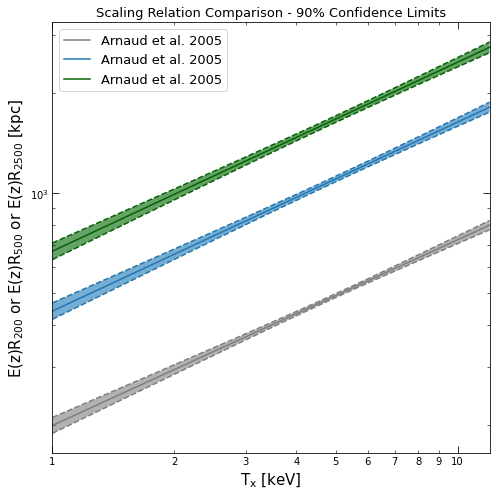

In [2]:
(arnaud_r2500 + arnaud_r500 + arnaud_r200).view(figsize=(7, 7))

### Step 2 - Iterate until convergence

Now that we have used the starting fixed aperture to measure/predict a temperature and estimate a radius, we will iterate and repeat this process, using the new radius estimate to generate/fit a new set of spectra for each cluster, and then using the resulting new temperature measurement to estimate a radius value.

A cluster radius is considered to be converged (which is when it is accepted and will not change anymore) if the new radius estimate is within a certain percentage of the last estimate (the convergence fraction can be set by the user, and the default value is 0.1 / 10%). 

Convergence can only occur once a minimum number of iterations has taken place (the user can set this value, and the default is 3), and the iterative process will exit either when all clusters have 'accepted' radii, or when the maximum number of iterations is reached (again can be set by the user, the default is 10).

It is quite possible that spectral fitting will fail for some of the clusters during one of these iterations. If that is the case then a temperature estimate has not been produced and the pipeline cannot continue to analyse that particular cluster. Such clusters are removed from the XGA sample, though whatever progress they made through the iterations will still be recorded in the radii history dataframe (see step 4).

### Step 3 - Measure results for the final radii

Once the iterative process has concluded, hopefully (but not necessarily) with no clusters dropping out and all of the radii successfully converging, there is another call to the XGA `single_temp_apec` function. As some clusters may only have achieved radius convergence in the very last iteration, they may not yet have temperature/luminosity measurements for those radii. Calling `single_temp_apec` after the iterative process is over ensures that there are measurements in those cases.

Finally, if the user has indicated (through setting `core_excised=True` in the pipeline call) that they wish to also measure core-excised results (where spectra are generated in the [0.15-1]$R_{\Delta}$ region, and then fit), there will be another call to `single_temp_apec`. If the user sets `core_excised=True` when the scaling relation is for $R_{2500}$, there will be a warning shown at the beginning to ensure that they meant for this behaviour.

**Note** - Setting `core_excised=True` will provide core-excised results _in addition_ to global results, not instead of. 

### Step 4 - Record results and radius history

Once all spectral generation and fitting are complete, the final results (in the form of a Pandas dataframe) will be put together for the user. Not every entry in the input `sample_data` dataframe will necessarily be present in the output results dataframe; if a cluster was found to have no X-ray data by the ClusterSample declaration, then it will not be included, but objects that failed part way through the iterative process **will** be included (though with NaN entries for the measurements). 

A dataframe containing the history of the radii through the various iterative steps will also be produced. Again this will only contain entries for those clusters which have some X-ray data, but will contain clusters that failed part way through the iterative process. For those that failed part way through, all entries for after their failure will be NaN values. The final column in this dataframe indicates whether the radius is considered to be converged or not, as it is possible to have entries for all iteration steps and it still not be converged because it reached the iteration limit set by `max_iter`.

If the pipeline is being used interactively, the ClusterSample created for the analysis will be the first entry in the tuple returned by the pipeline function, the results dataframe will be the second entry, and the radius history dataframe the last. 

The user may instead (or additionally) choose to **write the results and radius history dataframes to csv**, by setting the `save_samp_results_path` and `save_rad_history_path` variables with the paths to save the files to.

## Demonstrating the pipeline

In this case we will use the pipeline interactively, and capture the returned ClusterSample, results dataframe, and radius history dataframe, as well as setting the variables necessary to write the results/radius history dataframes to disk. 

There are quite a few configuration options, but we will largely leave things on the default settings for this demonstration. To give you an idea of what you can change, take a look at the docstring of the function printed below (you can access this in Jupyter by hitting `shift+tab` while your caret is inside the function brackets, or you can look at it in the XGA API documentation entry for [luminosity_temperature_pipeline](../../xga.tools.rst#xga.tools.clusters.LT.luminosity_temperature_pipeline)):

In [3]:
print(luminosity_temperature_pipeline.__doc__)


    This is the XGA pipeline for measuring overdensity radii, and the temperatures and luminosities within the
    radii, for a sample of clusters. No knowledge of the overdensity radii of the clusters is required
    beforehand, only the position and redshift of the objects. A name is also required for each of them.

    The pipeline works by measuring a temperature from a spectrum generated with radius equal to the
    'start_aperture', and the using the radius temperature relation ('rad_temp_rel') to infer a value for the
    overdensity radius you are targeting. The cluster's overdensity radius is set equal to the new radius estimate
    and we repeat the process.

    A cluster radius measurement is accepted if the 'current' estimate of the radius is considered to be converged
    with the last estimate. For instance if 'convergence_frac' is set to 0.1, convergence occurs when a change of
    less than 10% from the last radius estimate is measured. The radii cannot be assessed fo

### Loading the example sample

In this case we use a subset of a sample of 150 clusters selected from SDSS, analysed by the XMM Cluster Survey (XCS), and that have been found to have well constrained temperature measurements ([Giles et al. 2022](https://arxiv.org/abs/2202.11107)). The subset consists of 40 clusters, selected randomly. 

The sample file contains coordinates, which are derived from XCS X-ray centroid measurements using the XAPA source finder. It also contains redshift values, which come from the redMaPPer catalogue that the SDSSRM-XCS sample was selected from initially. The names in the sample combine an XCSSDSS prefix with the 'MEM_MATCH_ID' entry in the original SDSS redMaPPeR catalogue. XCS measurements of $R_{500}$ are present in the sample, though only to provide a point of comparison, **they are not used by the pipeline**. 

In [4]:
samp = pd.read_csv('lt_examp_samp.csv')
samp.info()
samp.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      40 non-null     object 
 1   ra        40 non-null     float64
 2   dec       40 non-null     float64
 3   redshift  40 non-null     float64
 4   xcs_r500  40 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.7+ KB


,name,ra,dec,redshift,xcs_r500
0,SDSSXCS-487,323.799200,-1.049468,0.333912,1103.195128
1,SDSSXCS-17923,350.470410,19.893604,0.314943,488.754689
2,SDSSXCS-5977,35.868932,-8.868981,0.167958,778.068206
3,SDSSXCS-890,126.489460,4.246014,0.234921,960.169165
4,SDSSXCS-30950,251.929730,34.936056,0.249875,556.325349


### Calling the pipeline function

Here we run the pipeline, telling it to use a 500kpc aperture for the starting measurements, and to produce core-excised measurements as well as global measurements. As already stated we have largely used the default settings for this run, but it is important to note that you can easily select the cosmology that you wish to use for analysis by setting the `cosmo=` argument with an Astropy cosmology object (the default is a flat LambdaCDM concordance model).

We're using the RA and Dec supplied by the user as the central coordinates of our spectra, but it is also possible to set `use_peak=True`, to let XGA identify an X-ray peak coordinate for each of the clusters and use that instead:

In [5]:
srcs, res, rad_hist = luminosity_temperature_pipeline(samp, Quantity(500, 'kpc'), core_excised=True,
                                                      save_samp_results_path='sdssrm_results.csv',
                                                      save_rad_history_path='sdssrm_radii_history.csv')

Generating products of type(s) expmap: 100%|██████████████████████████████████| 13/13 [00:00<00:00, 16.95it/s]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()
Running XSPEC Fits: 100%|█████████████████████████████████████████████████████| 40/40 [04:49<00:00,  7.23s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/relation.py:783: UserWarning: Some of the x values you have passed are outside the validity range of this relation (1.0-12.0keV).
  warn("Some of the x values you have passed are outside the validity range of this relation "
Running XSPEC Fits: 100%|█████████████████████████████████████████████████████| 40/40 [04:41<00:00,  7.04s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/relation.py:783: UserWarning: Some of the x values you have passed are outsi

### Looking at the pipeline output

The first thing returned by the pipeline function is the ClusterSample object which was used for the analysis - this contains the GalaxyCluster objects which were not removed from the sample during the iterative process (or could be single GalaxyCluster object if only one was passed through the pipeline).

Here we know it will be a sample, because we are looking at a sample of 40 clusters, and we can just look at some basic summary information:

In [6]:
srcs.info()


-----------------------------------------------------
Number of Sources - 40
Redshift Information - True
Sources with ≥1 detection - 40 [100%]
-----------------------------------------------------



The next return is the results dataframe, which contains the columns from the original input dataframe, as well as the measured temperatures, luminosities, and radii. As we passed a value to `save_samp_results_path` in the pipeline function call, this dataframe is also being saved as a csv.

**Note** - if we had chosen to set `use_peak=True` when we called the pipeline function, there would be an entry for peak RA and peak Dec in the results dataframe, alongside the temperature, luminosity, and radius values.

First off, we'll take a look at the top five rows of our output results:

In [7]:
res.head(5)

,name,ra,dec,redshift,xcs_r500,r500,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,...,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,SDSSXCS-487,323.799200,-1.049468,0.333912,1103.195128,1167.001129,7.38030,0.461906,0.495718,3.510844e+44,...,3.420190e+43,7.35291,0.587741,0.636899,2.614441e+44,7.118180e+42,6.511809e+42,1.038449e+45,3.906718e+43,4.005130e+43
1,SDSSXCS-17923,350.470410,19.893604,0.314943,488.754689,443.195494,1.42470,0.138240,0.196310,6.783900e+42,...,2.308638e+42,1.40173,0.129780,0.184037,6.394102e+42,8.902959e+41,1.103822e+42,1.253464e+43,2.149948e+42,2.342160e+42
2,SDSSXCS-5977,35.868932,-8.868981,0.167958,778.068206,707.035947,2.81196,0.395739,0.486902,2.659669e+43,...,5.661870e+42,3.06433,0.555269,0.672173,1.837119e+43,2.087220e+42,2.514942e+42,4.797792e+43,6.262681e+42,7.989428e+42
3,SDSSXCS-890,126.489460,4.246014,0.234921,960.169165,959.116962,4.78606,0.200513,0.220079,1.661848e+44,...,1.188377e+43,4.92848,0.291353,0.312509,1.087360e+44,2.237170e+42,2.686739e+42,3.528936e+44,1.254143e+43,9.215954e+42
4,SDSSXCS-30950,251.929730,34.936056,0.249875,556.325349,518.753784,1.57751,0.131621,0.162688,6.839353e+42,...,1.408927e+42,1.60072,0.132661,0.198595,6.642926e+42,7.034819e+41,5.962644e+41,1.382094e+43,1.570607e+42,1.265908e+42


Then we can see some summary statistics for all of the columns in the dataframe:

In [8]:
res.describe()

,ra,dec,redshift,xcs_r500,r500,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,...,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,4.000000e+01,4.000000e+01,...,4.000000e+01,40.000000,40.000000,40.000000,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01
mean,170.845067,14.129411,0.226732,853.116880,839.470056,4.016504,0.197688,0.234105,1.754471e+44,2.523387e+42,...,1.158209e+43,4.052853,0.237782,0.290976,1.192408e+44,2.434959e+42,2.408247e+42,4.343402e+44,1.095071e+43,1.054230e+43
std,109.002087,14.427955,0.071969,238.719870,248.748739,2.094706,0.133090,0.172728,2.709387e+44,3.416941e+42,...,1.592950e+43,2.070156,0.161917,0.257692,1.572231e+44,3.187407e+42,2.893337e+42,6.538151e+44,1.495431e+43,1.461325e+43
min,4.406325,-8.868981,0.100436,340.505584,329.424037,0.976955,0.020285,0.026422,2.550508e+42,3.659965e+41,...,9.732723e+41,0.927612,0.050021,0.050025,2.208393e+42,3.189711e+41,2.821091e+41,3.683191e+42,1.346079e+42,9.739682e+41
25%,104.022664,2.516330,0.166746,753.451777,705.347318,2.636328,0.119683,0.122921,2.294106e+43,7.568225e+41,...,2.392147e+42,2.755397,0.131244,0.143492,1.818083e+43,7.711982e+41,7.825187e+41,4.604337e+43,2.432083e+42,2.324675e+42
50%,184.878080,11.986612,0.229464,846.063105,832.495652,3.523850,0.158468,0.188769,6.914379e+43,1.278640e+42,...,5.159838e+42,3.777330,0.182779,0.218441,4.903966e+43,1.425523e+42,1.522321e+42,1.482090e+44,5.224442e+42,4.826215e+42
75%,227.912807,26.541525,0.282091,962.179869,951.189710,4.623258,0.214286,0.285795,2.108054e+44,2.677140e+42,...,1.201834e+43,4.616825,0.292304,0.309565,1.520532e+44,2.300037e+42,2.542027e+42,4.382001e+44,1.300986e+43,1.048910e+43
max,350.470410,47.052785,0.349364,1424.488110,1380.260297,9.087740,0.591217,0.728980,1.355846e+45,1.685934e+43,...,7.047270e+43,8.897410,0.762056,1.493671,6.101462e+44,1.317662e+43,1.218105e+43,2.545512e+45,6.082700e+43,6.744091e+43


The last return from the pipeline function is the radius history dataframe, which tells you what the estimated radius was at each iterative step for each galaxy cluster which had X-ray data. It will also tell you if the radius was considered to be converged or not, which can provide context for the information given in the results dataframe:

In [9]:
rad_hist.head(5)

,0,1,2,3,4,5,converged
SDSSXCS-487,500.0,1124.165421,1149.921395,1162.776447,1167.001129,1167.001129,True
SDSSXCS-17923,500.0,476.645964,464.262874,456.537207,443.195494,443.195494,True
SDSSXCS-5977,500.0,784.721678,688.894894,742.935950,707.035947,707.035947,True
SDSSXCS-890,500.0,928.603453,974.196493,950.556860,959.116962,959.116962,True
SDSSXCS-30950,500.0,522.166575,494.996261,509.986735,518.753784,518.753784,True


### How did the radius evolve with iterative steps?

We can use the radius history to produce a little diagnostic plot that shows the value of radius measured for the clusters (no legend is included here because of the large number of clusters that we are working with) at each iterative step:

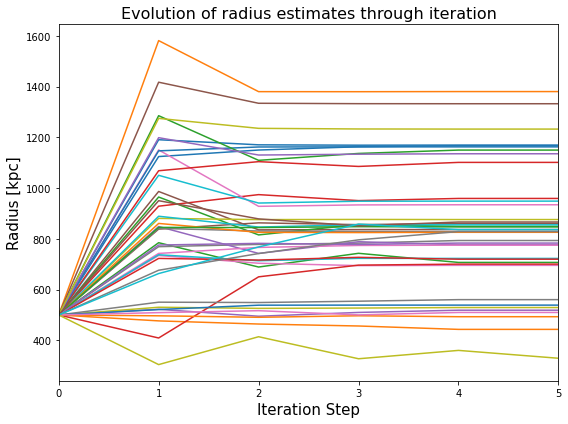

In [10]:
plt.figure(figsize=(8, 6))
clust_rad_arr = rad_hist.values[:, :-1]
for cl_ind in range(0, len(clust_rad_arr)):
    plt.plot(np.arange(0, clust_rad_arr.shape[1]), clust_rad_arr[cl_ind, :])

plt.xlim(0, clust_rad_arr.shape[1]-1)
plt.ylabel('Radius [kpc]', fontsize=15)
plt.xlabel('Iteration Step', fontsize=15)
plt.title("Evolution of radius estimates through iteration", fontsize=(16))
plt.tight_layout()
plt.show()

### Comparing XGA-LT radii to XCS3P radii

As we have the $R_{500}$ values measured for these clusters for the [Giles et al. (2022)](https://arxiv.org/abs/2202.11107) analysis, we will compare our measurements of radius to those. We do not compare the measurements of temperature and luminosity, as that has already been done as part of a paper on cluster hydrostatic masses by Turner et al. (in prep); they were found to be very consistent.

We do not expect to find that the radii measured by the XGA pipeline to be identical to the previous measurements, as there are slight differences in the approach (such as we use a fixed starting aperture, but the past analysis used a starting aperture based on the size of the detection region), and XGA is an entirely separate code-base to the previous XCS pipelines, but we do expect the results to be very similar. XGA has been developed by members of XCS, and there are numerous similarities in the approaches it takes to previous XCS work:

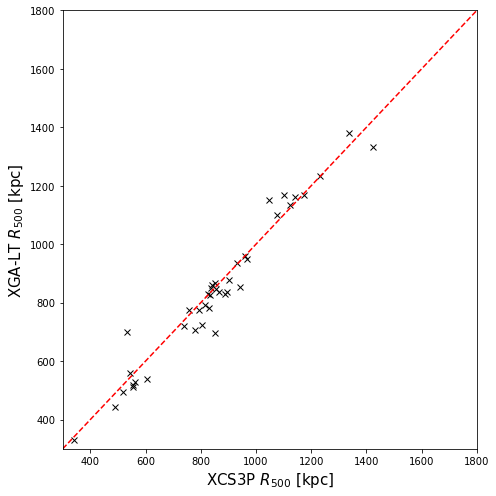

In [11]:
plt.figure(figsize=(7, 7))

plt.plot(res['xcs_r500'].values, res['r500'], 'x', color='black', label='Data')
plt.plot([300, 1800], [300, 1800], color='red', linestyle='dashed', label='1:1')

plt.xlim(300, 1800)
plt.ylim(300, 1800)

plt.xlabel("XCS3P $R_{500}$ [kpc]", fontsize=15)
plt.ylabel("XGA-LT $R_{500}$ [kpc]", fontsize=15)

plt.tight_layout()
plt.show()

## Demonstrating the pipeline - 'frozen temperature' mode

As has been mentioned in other parts of this tutorial, frozen-temperature mode does not allow the temperature to be a free parameter in the spectral fits - instead we leave the fit to essentially constrain the normalisation of the model, and use the luminosity calculated from that model to predict a temperature to be used as the fixed temperature for the next fit.

This method is intrinsically less sophisticated than the standard method, but it can help when dealing with very low surface-brightness systems, or with low quality data.

### A temperature-luminosity relation

An extra relation is required for 'frozen temperature' mode, which allows us to convert from the luminosities measured by each iteration into an estimate of the temperature of the system:

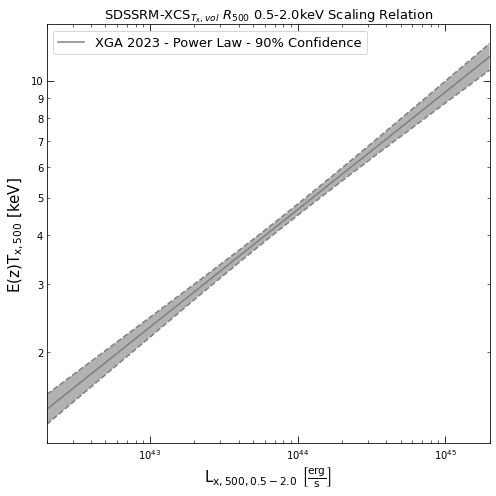

In [12]:
xcs_sdss_r500_52_TL.view(figsize=(7, 7), x_lims=Quantity([2e+42, 2e+45], 'erg/s'))

### Calling the pipeline function

Here we call the pipeline much as we did earlier, but instead we set `freeze_temp=True`, and `temp_lum_rel=xcs_sdss_r500_52_TL` (this gives the pipeline the temperature-luminosity relation, though the default value is the relation that we have passed here):

In [13]:
tfr_srcs, tfr_res, tfr_rad_hist = luminosity_temperature_pipeline(samp, Quantity(500, 'kpc'), core_excised=True, 
                                                                  freeze_temp=True, 
                                                                  temp_lum_rel=xcs_sdss_r500_52_TL)

/tmp/ipykernel_25265/1013608433.py:1: UserWarning: Core-excised temperatures will not be reported when running in frozen-temperature mode.
  tfr_srcs, tfr_res, tfr_rad_hist = luminosity_temperature_pipeline(samp, Quantity(500, 'kpc'), core_excised=True,
Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 40/40 [01:07<00:00,  1.69s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()
Running XSPEC Fits: 100%|█████████████████████████████████████████████████████| 40/40 [01:40<00:00,  2.52s/it]


### Comparing XGA-LT frozen-temperature radii to XCS3P radii

Much as we did before, we compare the radii measured from the frozen-temperature mode measurements to the published values for this sample:

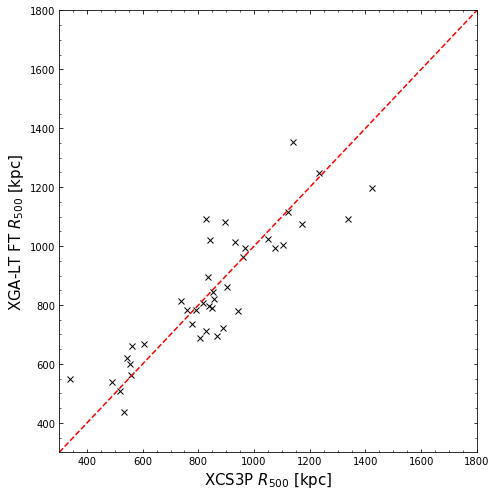

In [14]:
plt.figure(figsize=(7, 7))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.plot(tfr_res['xcs_r500'].values, tfr_res['r500'], 'x', color='black', label='Data')
plt.plot([300, 1800], [300, 1800], color='red', linestyle='dashed', label='1:1')

plt.xlim(300, 1800)
plt.ylim(300, 1800)

plt.xlabel("XCS3P $R_{500}$ [kpc]", fontsize=15)
plt.ylabel("XGA-LT FT $R_{500}$ [kpc]", fontsize=15)

plt.tight_layout()
plt.show()

### Comparing XGA-LT frozen-temperature radii to standard-mode XGA-LT radii

We also compare to the values we measured using 'standard mode', where the temperature were allowed to vary during the spectral fitting process:

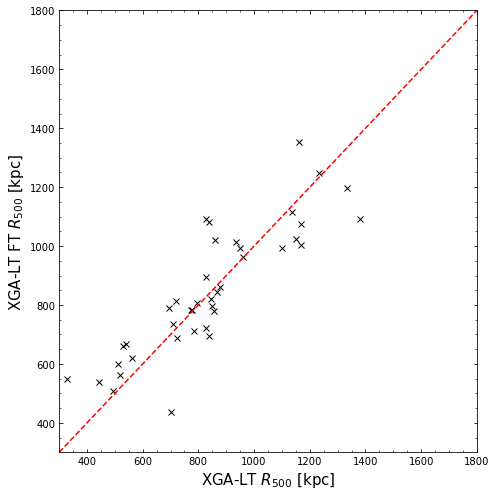

In [15]:
plt.figure(figsize=(7, 7))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.plot(res['r500'], tfr_res['r500'], 'x', color='black', label='Data')
plt.plot([300, 1800], [300, 1800], color='red', linestyle='dashed', label='1:1')

plt.xlim(300, 1800)
plt.ylim(300, 1800)

plt.xlabel("XGA-LT $R_{500}$ [kpc]", fontsize=15)
plt.ylabel("XGA-LT FT $R_{500}$ [kpc]", fontsize=15)

plt.tight_layout()
plt.show()